# Porto Seguro’s Safe Driver Prediction

## Overview of the Kaggle competition :
Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.


### Importing Packages

In [19]:
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib as mpl
import seaborn as sns
from collections import Counter
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

### Loading & Analysing Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

#### Visualising the Data :

In [3]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


#### Data Discription :
Each row is a client and they are independent. 595,212 unique clients are present in test set while 892,816 are present in the test set. 

The data consists of 57 input features, one target variable and a client ID. The target is 1 if the customer has filed a claim and 0 if not. In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). "Ind" is related to individual or driver, "reg" is related to region, "car" is related to car itself and "calc" is an calculated feature. In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. 17 of the 57 features are binary, 14 are categorical & the others are either continuous or ordinal.

In [4]:
print "Total number of input features : %d" %(train.shape[1] - 2) # id and target are not features, hence -2
print "Number of users in train : %d" %train.shape[0]
print "Number of users in test : %d" %test.shape[0]

Total number of input features : 57
Number of users in train : 595212
Number of users in test : 892816


#### Memory usage by Train and Test data

In [5]:
train.info(memory_usage='deep', verbose=False)
test.info(memory_usage='deep', verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Columns: 59 entries, id to ps_calc_20_bin
dtypes: float64(10), int64(49)
memory usage: 267.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Columns: 58 entries, id to ps_calc_20_bin
dtypes: float64(10), int64(48)
memory usage: 395.1 MB


#### Analysing Missing Data

In [6]:
print "Total NaN in train data : %d" %train.isnull().sum().sum()
print "Total NaN in test data : %d" %test.isnull().sum().sum()

Total NaN in train data : 0
Total NaN in test data : 0


There are no NaNs in either test or train data. But values of -1 indicate that the feature was missing from the observation.

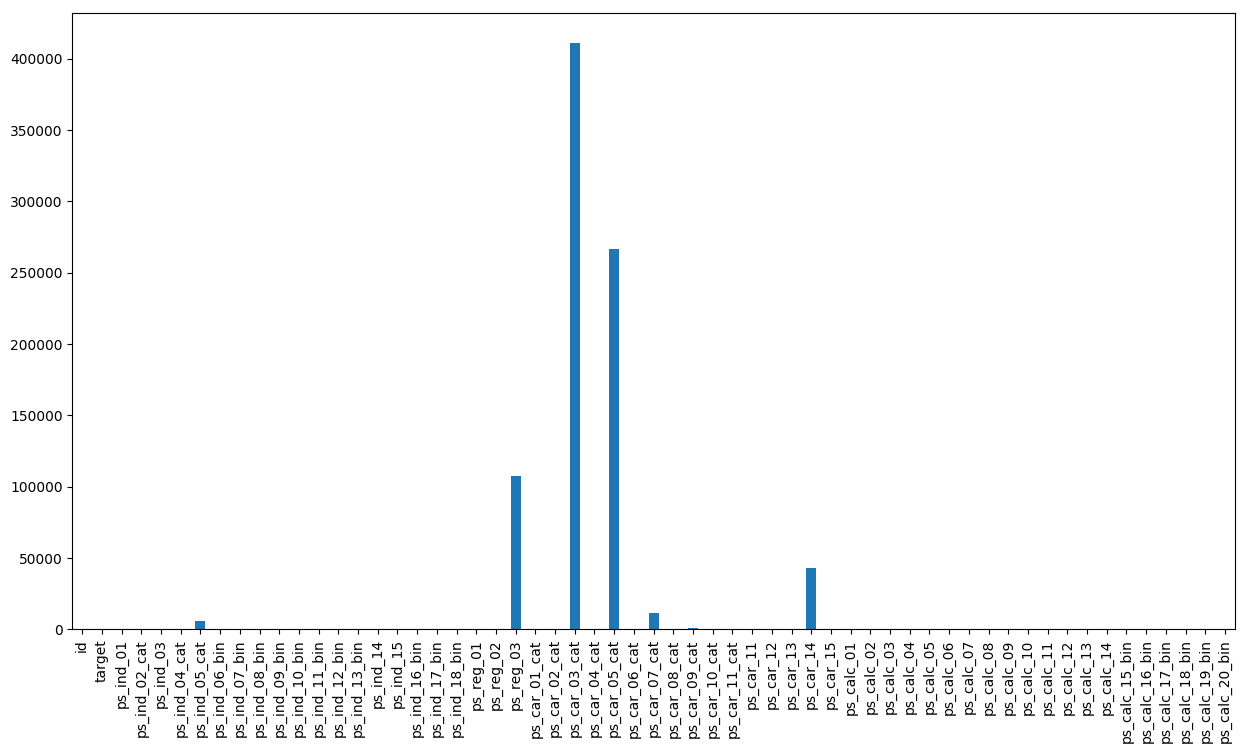

In [7]:
train_missing_count = (train == -1).sum()
plt.rcParams['figure.figsize'] = (15,8)
train_missing_count.plot.bar()
plt.show()

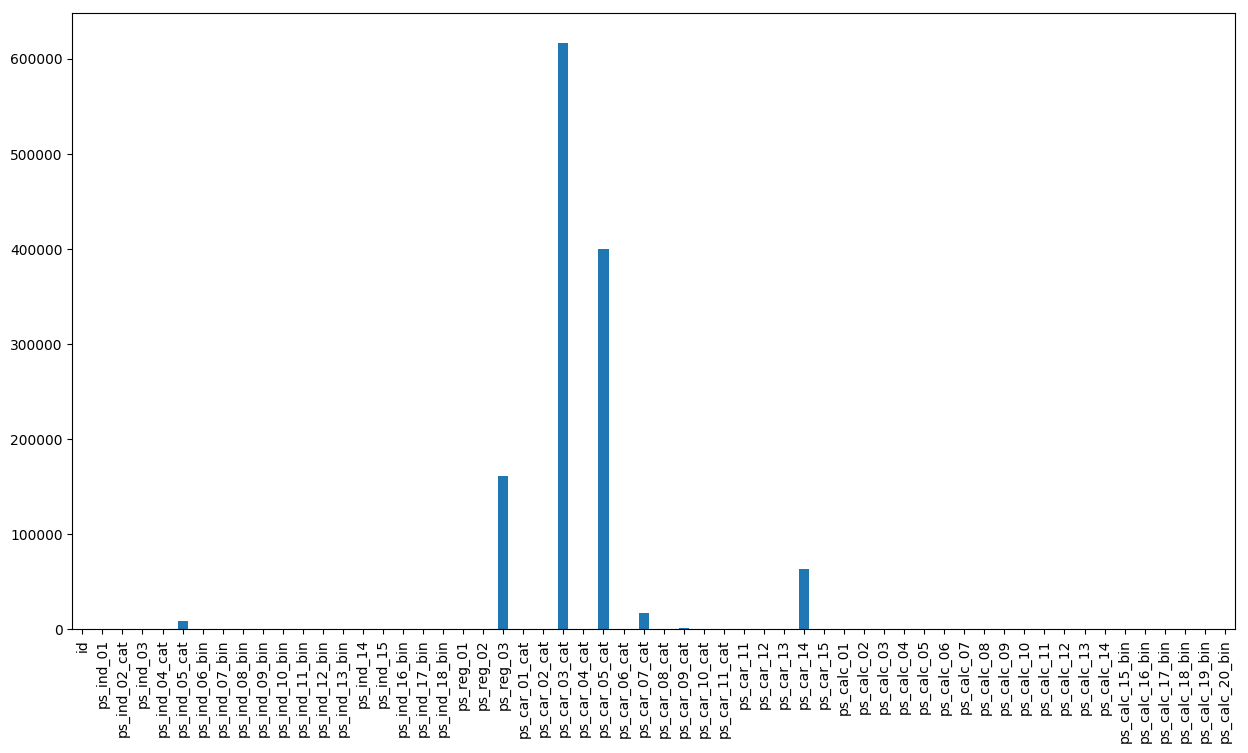

In [8]:
test_missing_count = (test == -1).sum()
test_missing_count.plot.bar()
plt.show()

#### Heatmap of Missing Data :

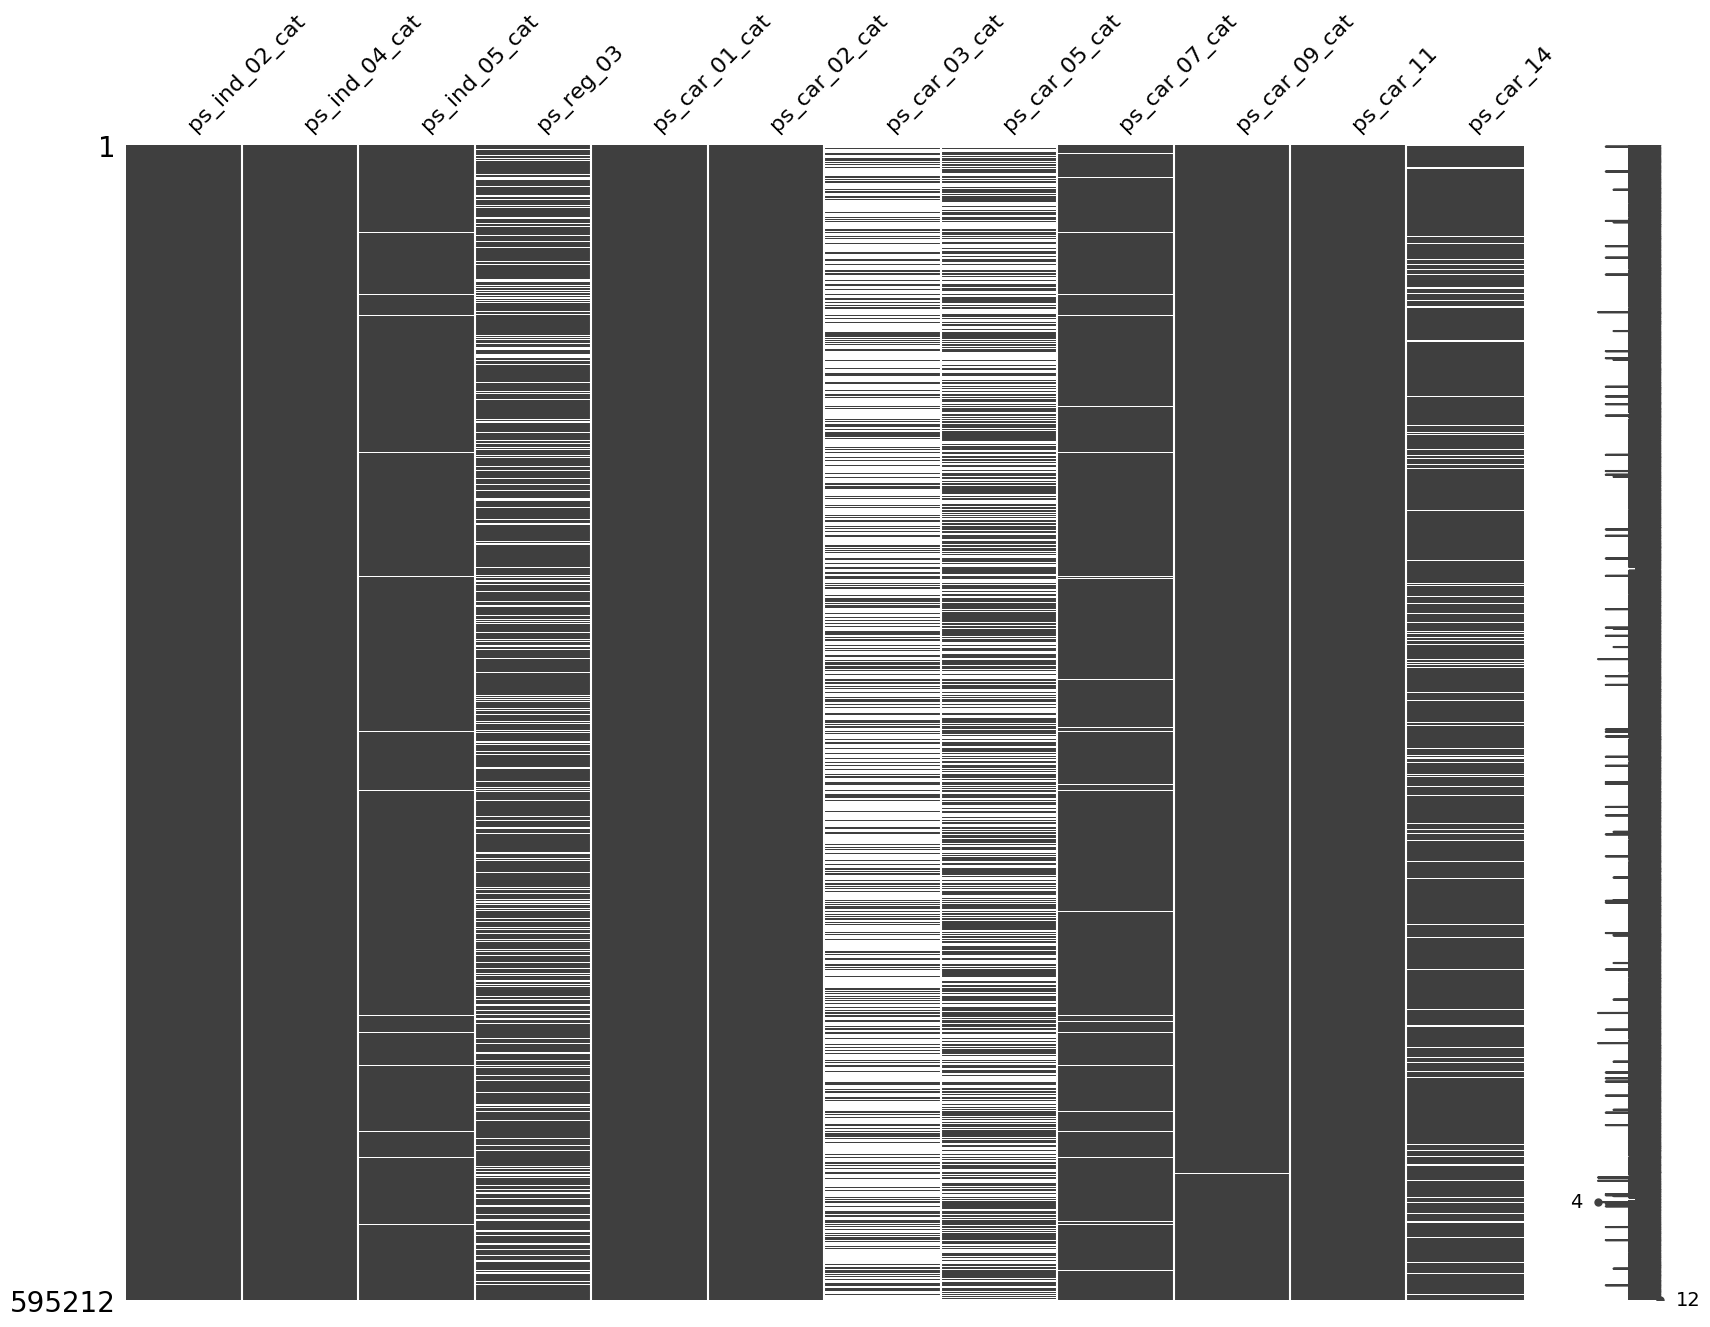

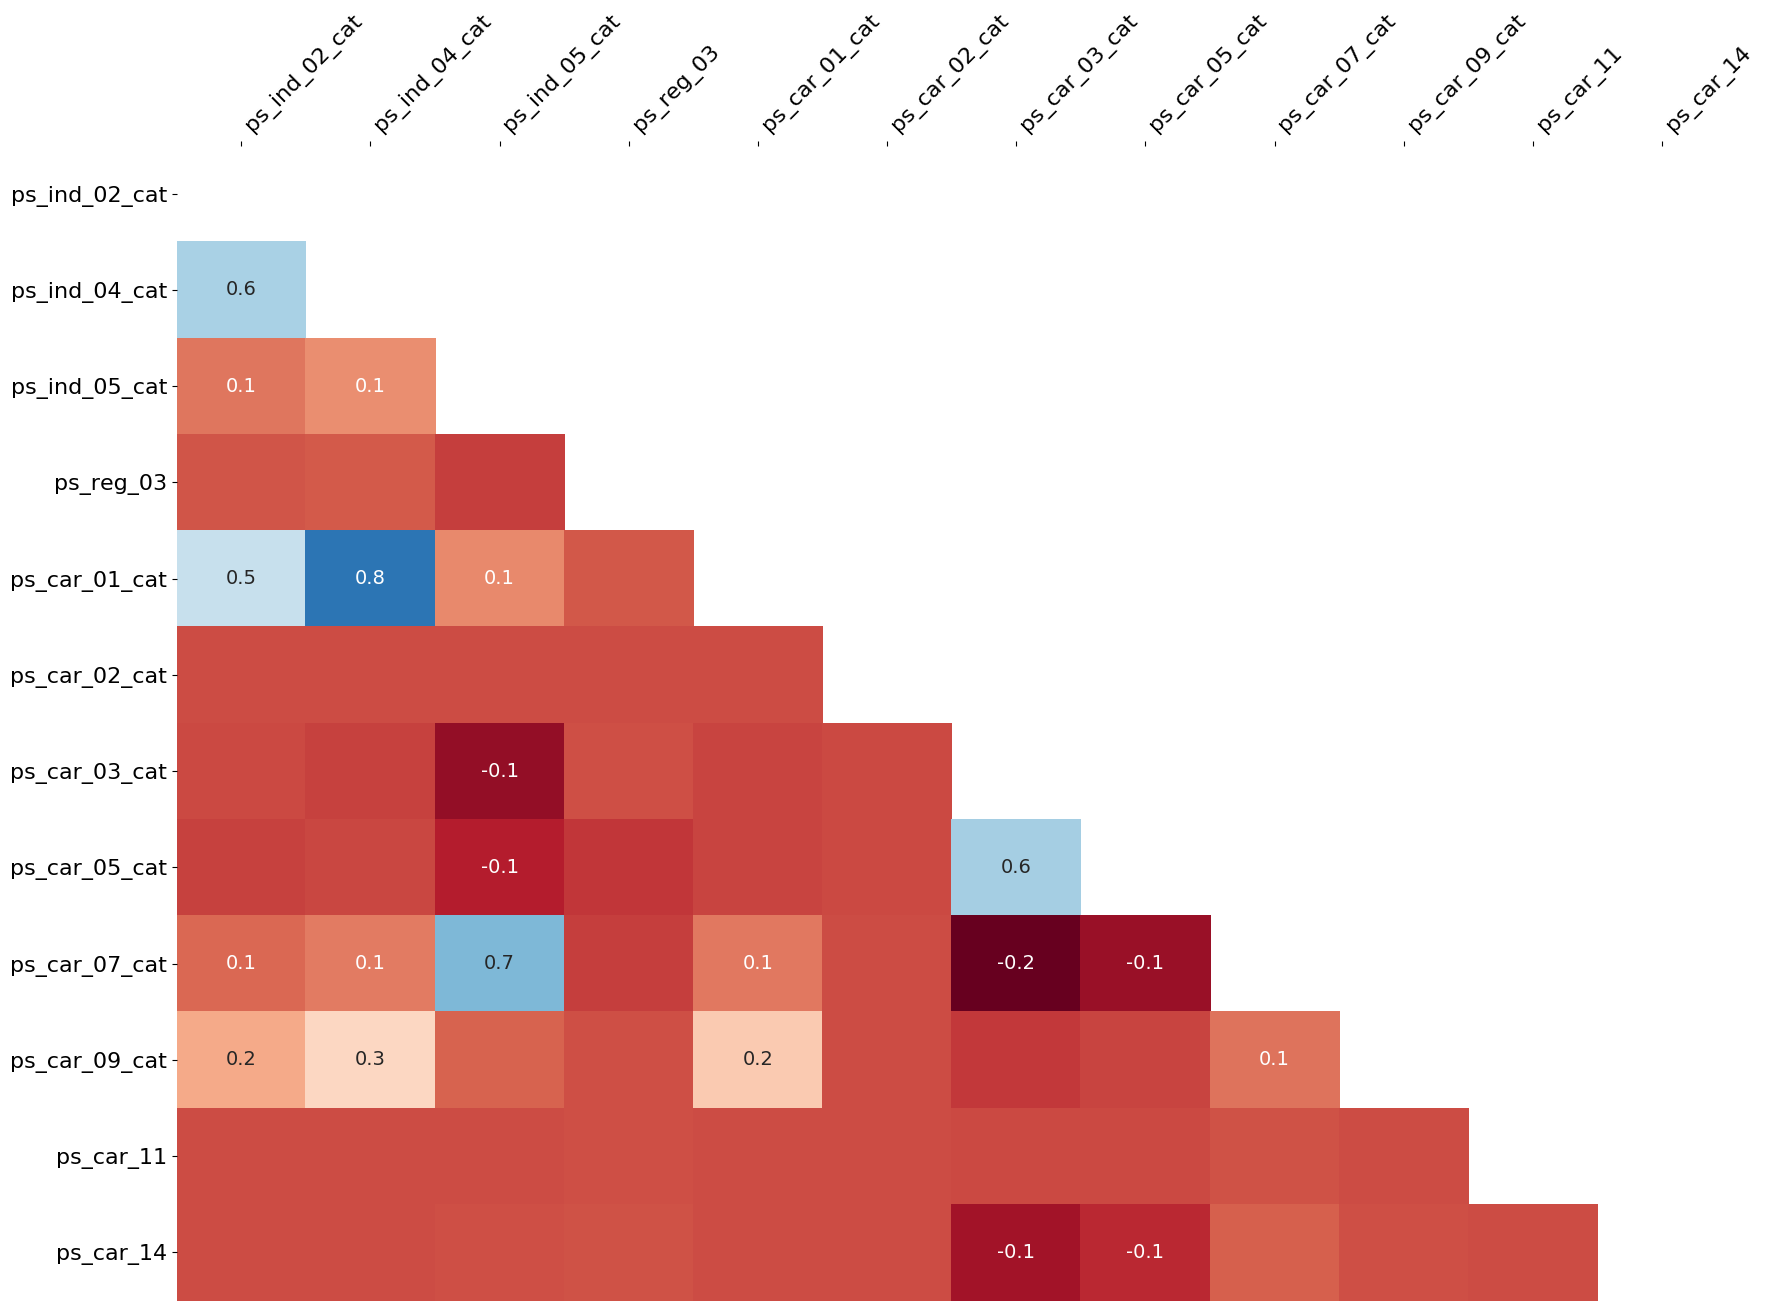

In [9]:
required_columns = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_14']
train_temp = train.copy()
train_temp = pd.DataFrame(train_temp, columns=required_columns)
train_temp = train_temp.replace(-1, np.NaN)
msno.matrix(df=train_temp, figsize=(20, 15))
msno.heatmap(train_temp,figsize=(20,15))
del train_temp

#### Closer view at training data :


In [10]:
train_statistics = train.iloc[:,2:].describe()
train_statistics

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Analysing Target Variable

21694 people claimed insurance and 573518 did not claim imsurance
3.644752% of the people claimed insurance and 96.355248% did not claim imsurance


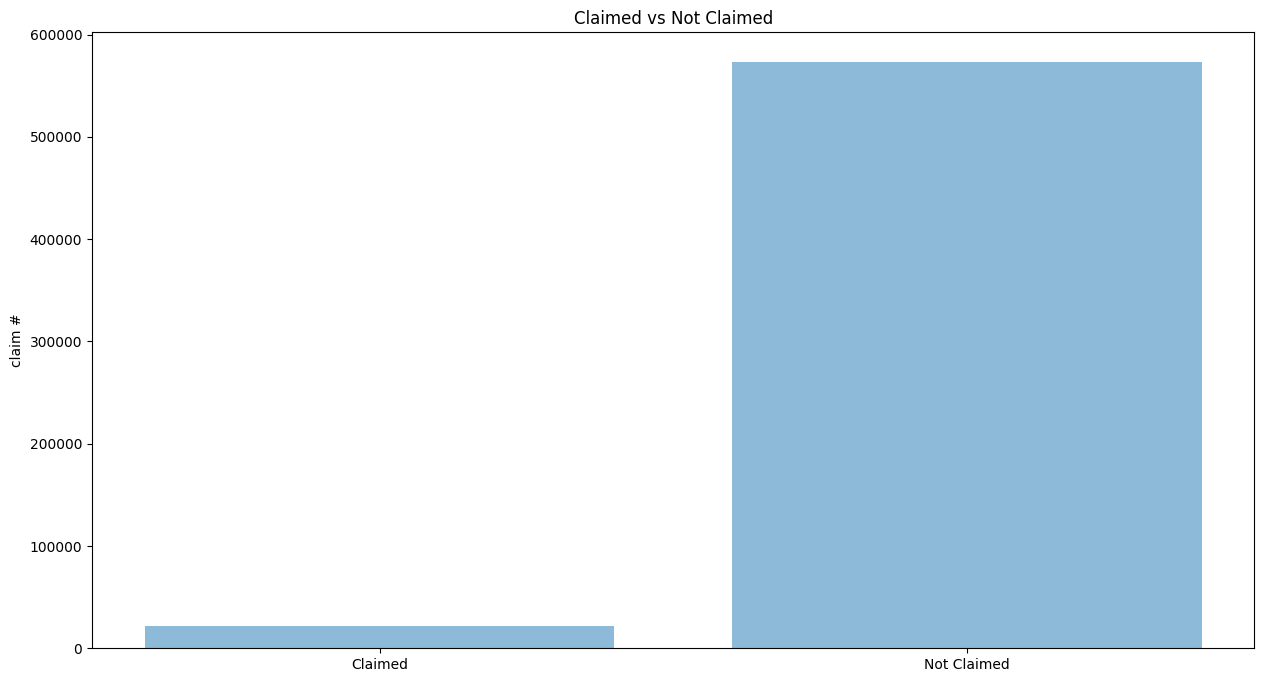

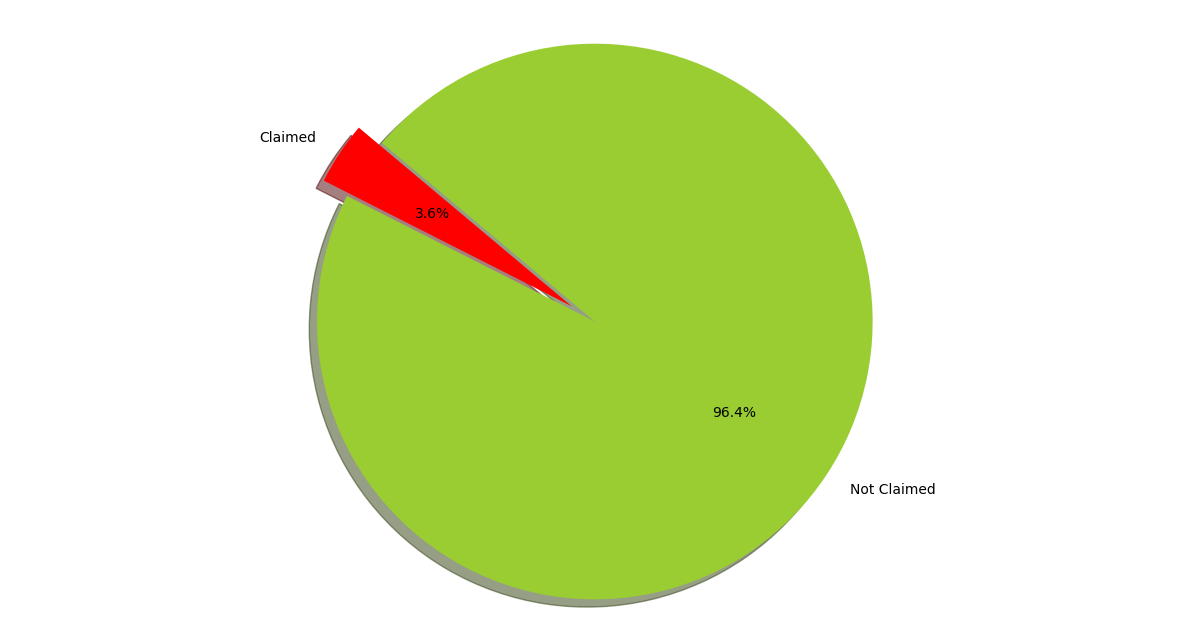

In [11]:
print "%d people claimed insurance and %d did not claim imsurance" %(train['target'].sum(), train.shape[0] - train['target'].sum())
print "%f%% of the people claimed insurance and %f%% did not claim imsurance" %((train['target'].sum()*100.0)/train.shape[0], ((train.shape[0] - train['target'].sum())*100.0)/train.shape[0])


objects = ('Claimed', 'Not Claimed')
y_pos = np.arange(len(objects))
performance = [train['target'].sum(), train.shape[0] - train['target'].sum()]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('claim #')
plt.title('Claimed vs Not Claimed')
plt.show()

objects = ('Claimed', 'Not Claimed')
colors = ['red', 'yellowgreen']
sizes = [(train['target'].sum()*100.0)/train.shape[0], ((train.shape[0] - train['target'].sum())*100.0)/train.shape[0]]
explode = (0.1, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=objects, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()


21694 people claimed insurance and 573518 did not claim imsurance.

3.64% of the people claimed insurance and 96.35% did not claim imsurance.

## Analysing each feature

### Binary Features :

In [12]:
unique_counter = Counter()
for col in train.columns:
    unique_counter[col] = len(np.sort(train[col].unique()))
binary_columns = [ col for col , val in unique_counter.items() if(val==2)]
binary_column_sum = []
for col in binary_columns:
    binary_column_sum.append(train[col].sum())
#List of binary columns
binary_columns

['ps_ind_16_bin',
 'ps_ind_09_bin',
 'ps_ind_13_bin',
 'ps_ind_11_bin',
 'ps_ind_08_bin',
 'ps_ind_06_bin',
 'ps_calc_15_bin',
 'ps_ind_17_bin',
 'ps_ind_10_bin',
 'ps_ind_07_bin',
 'ps_ind_12_bin',
 'ps_calc_19_bin',
 'ps_calc_16_bin',
 'ps_calc_20_bin',
 'ps_calc_18_bin',
 'target',
 'ps_calc_17_bin',
 'ps_car_08_cat',
 'ps_ind_18_bin']

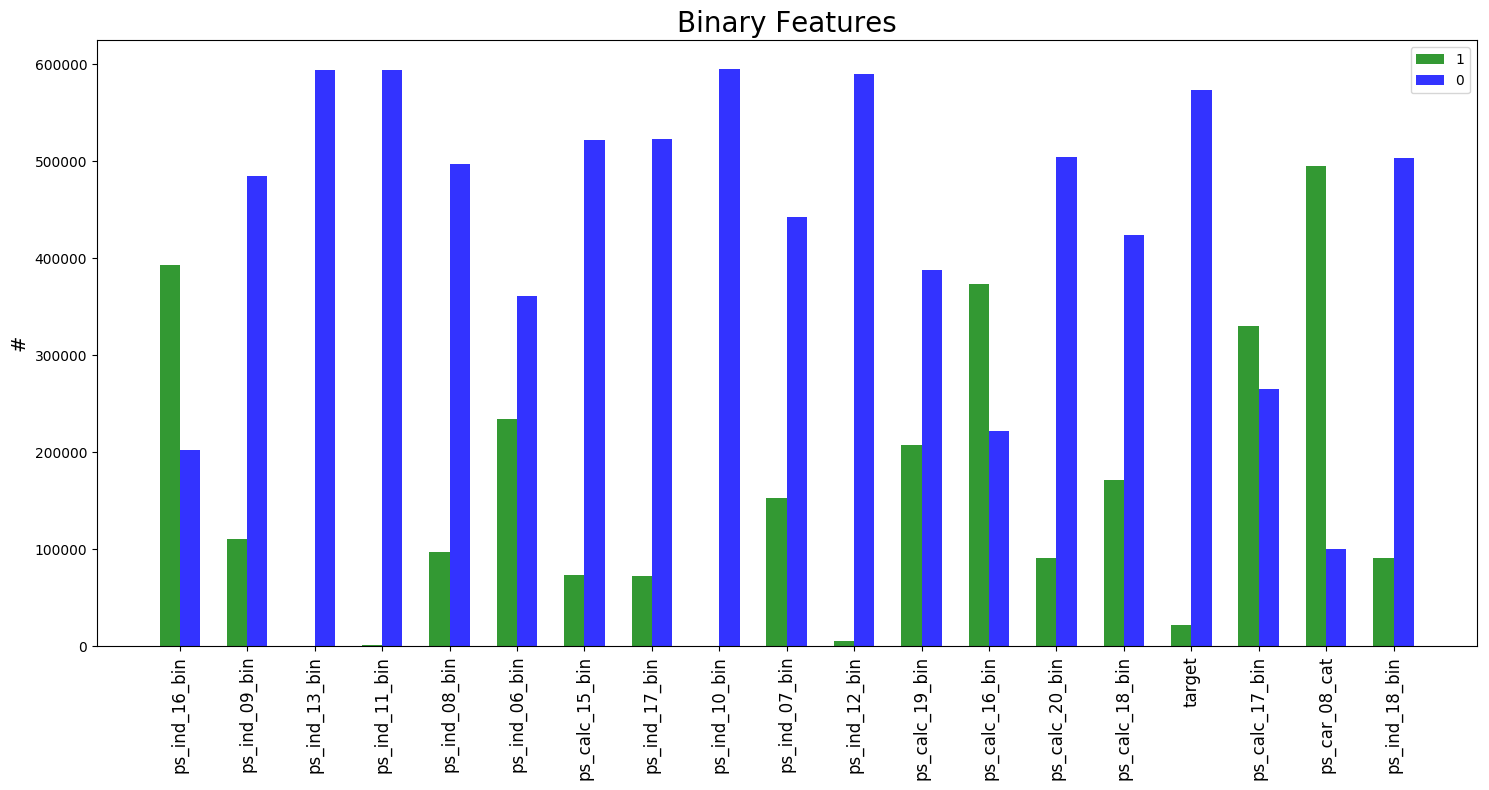

In [13]:
# data to plot
n_groups = len(binary_columns)
one_cols = binary_column_sum
zero_cols = train.shape[0] - np.asarray(binary_column_sum)
 
# create plot
plt.rcParams['figure.figsize'] = (15,8)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8
 
rects1 = plt.bar(index, one_cols, bar_width,
                 alpha=opacity,
                 color='g',
                 label='1')
 
rects2 = plt.bar(index + bar_width, zero_cols, bar_width,
                 alpha=opacity,
                 color='b',
                 label='0')

plt.ylabel('#', fontsize=14)
plt.title('Binary Features', fontsize=20)
plt.xticks(index + bar_width/2, binary_columns, rotation='vertical', fontsize=12)
plt.legend()
 
plt.tight_layout()
plt.show()

#### Catagorical and other Features

Histogram of train data viewing the distribution of data:

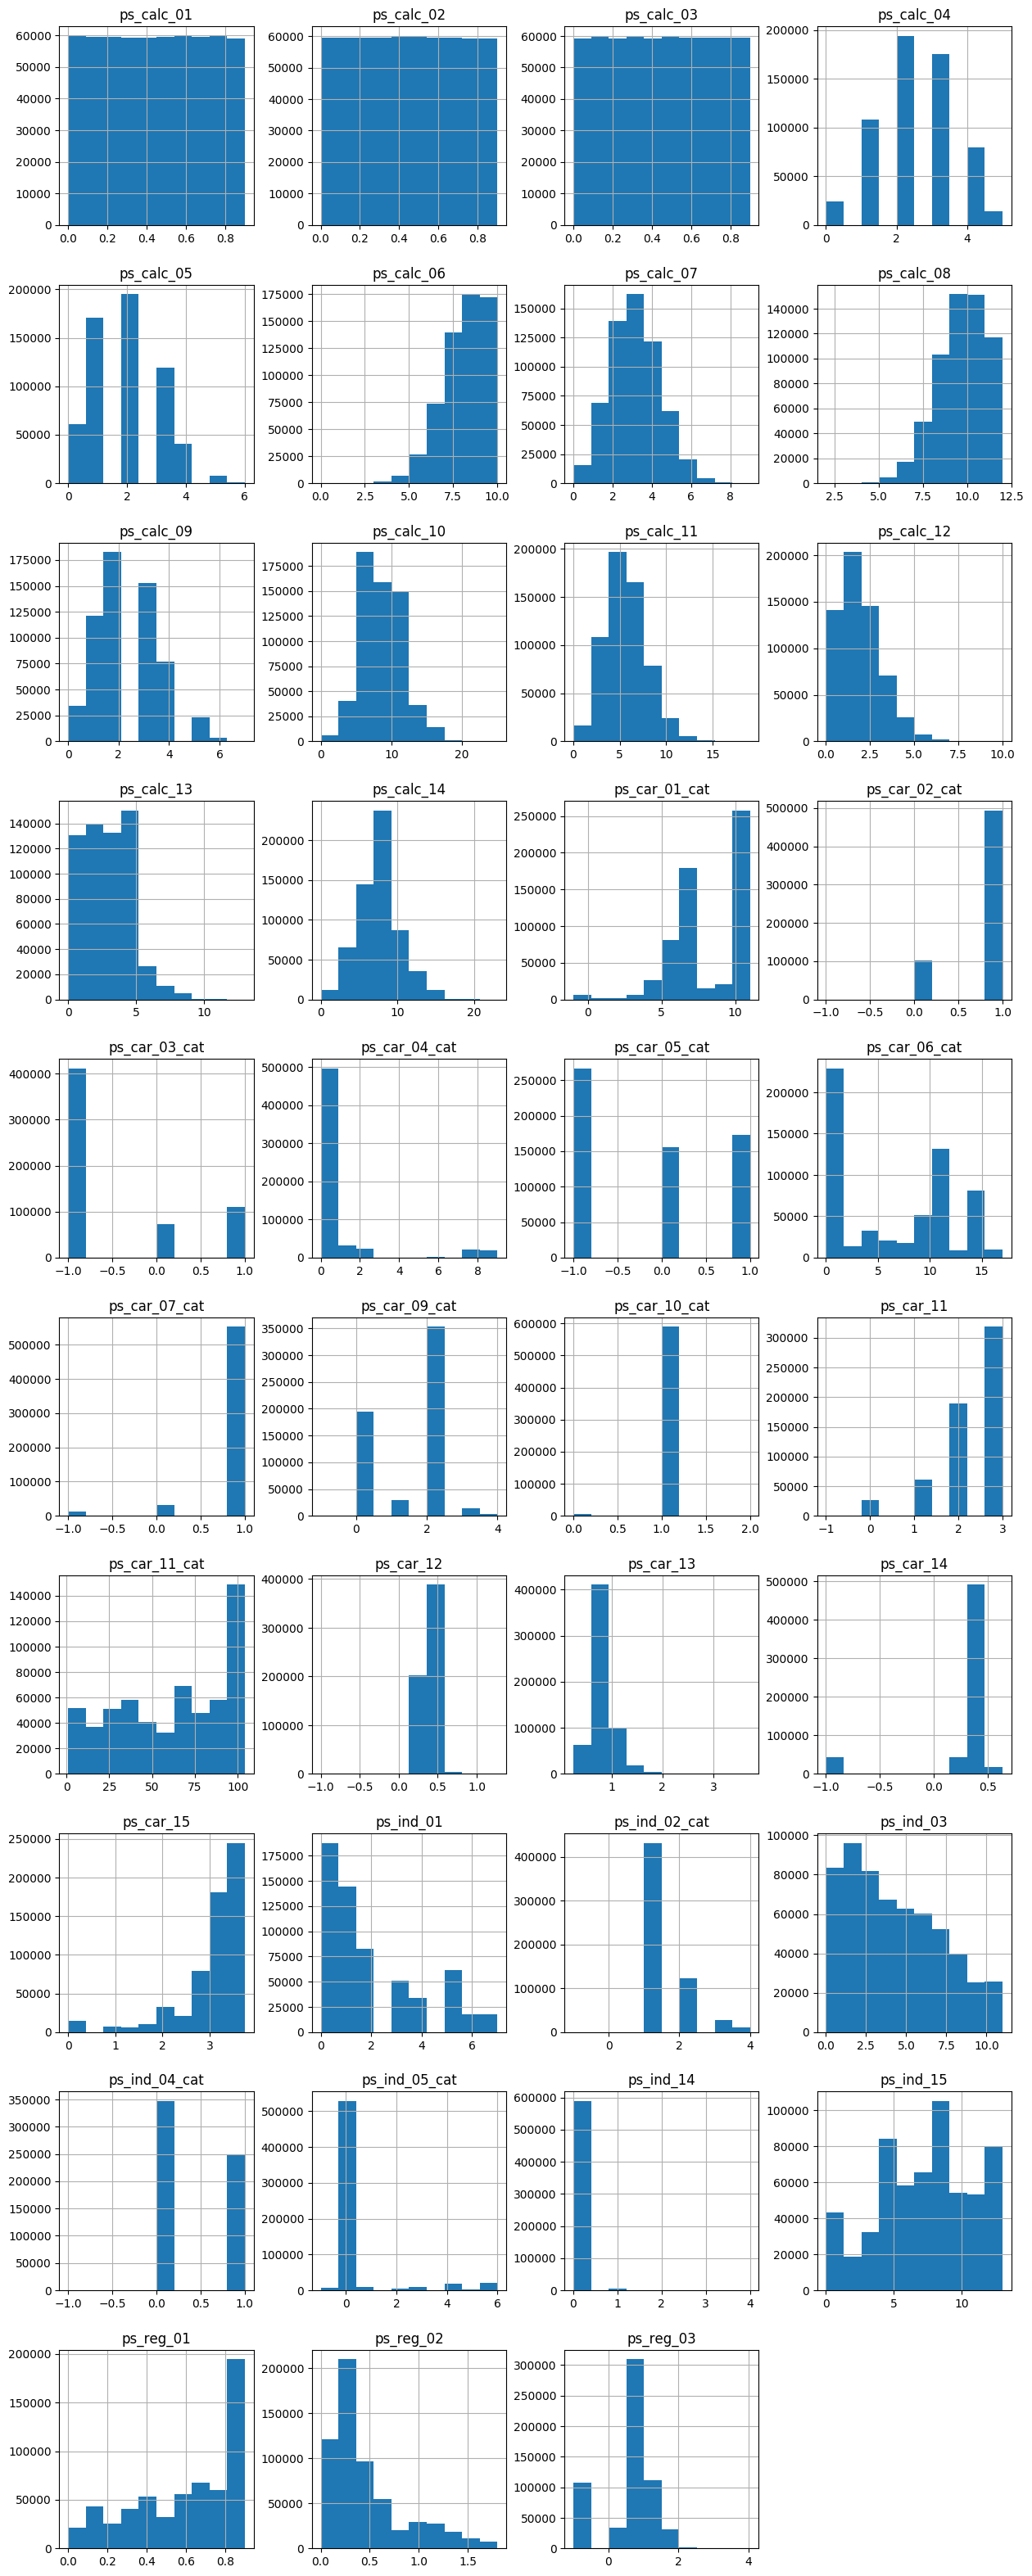

In [14]:
# Univariate Histograms
columns_multi = [x for x in list(train.columns) if x not in binary_columns]
columns_multi.remove('id')
columns_multi
plt.rcParams['figure.figsize'] = (15,40)
names = columns_multi
train.hist(layout = (10,4), column = columns_multi)
plt.show()

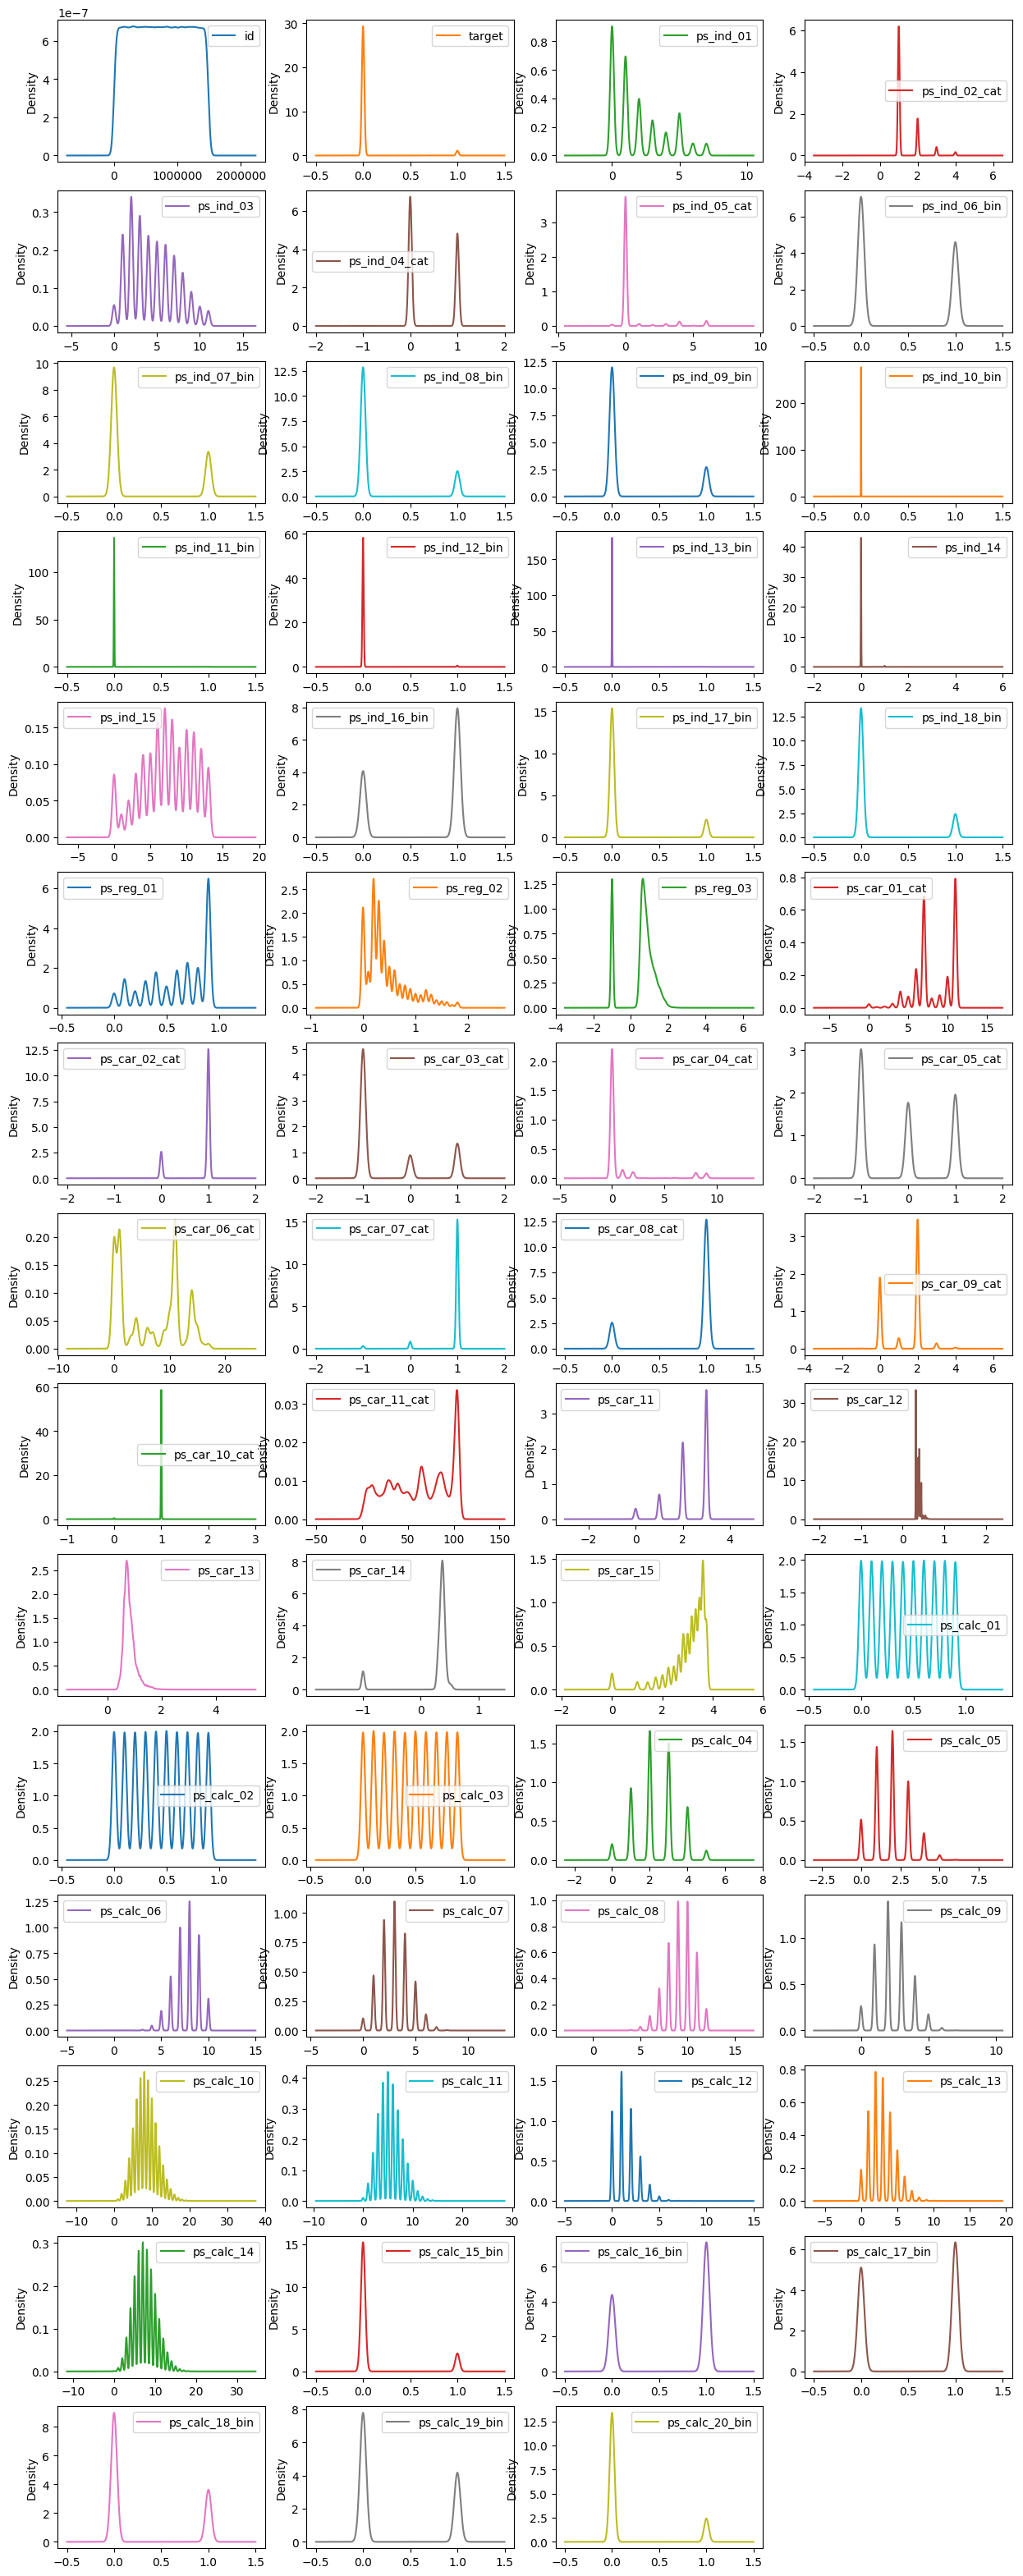

In [17]:
names = columns_multi
train.plot(kind='density', subplots=True, layout=(15,4), sharex=False)
plt.show()

## Correction of Train Data

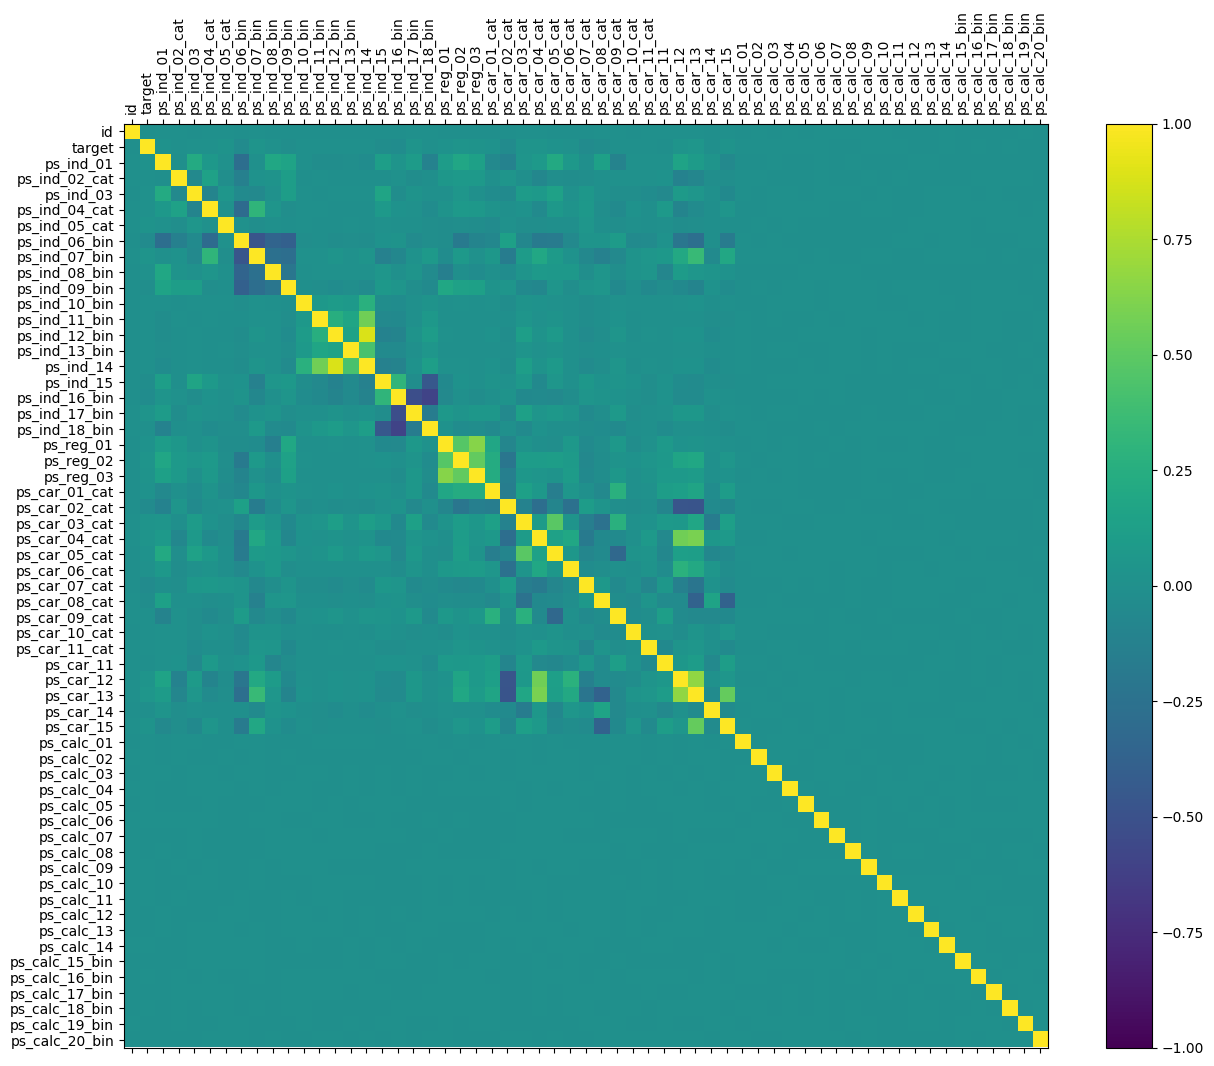

In [15]:
# Correction Matrix Plot
names = train.columns
correlations = train.corr()
# plot correlation matrix
plt.rcParams['figure.figsize'] = (15,12)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,59,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)
plt.show()

## Discovering Feature Importances :

Three methods are used
- Random Forest Classifier
- Extra Trees Classifier
- XGBoost

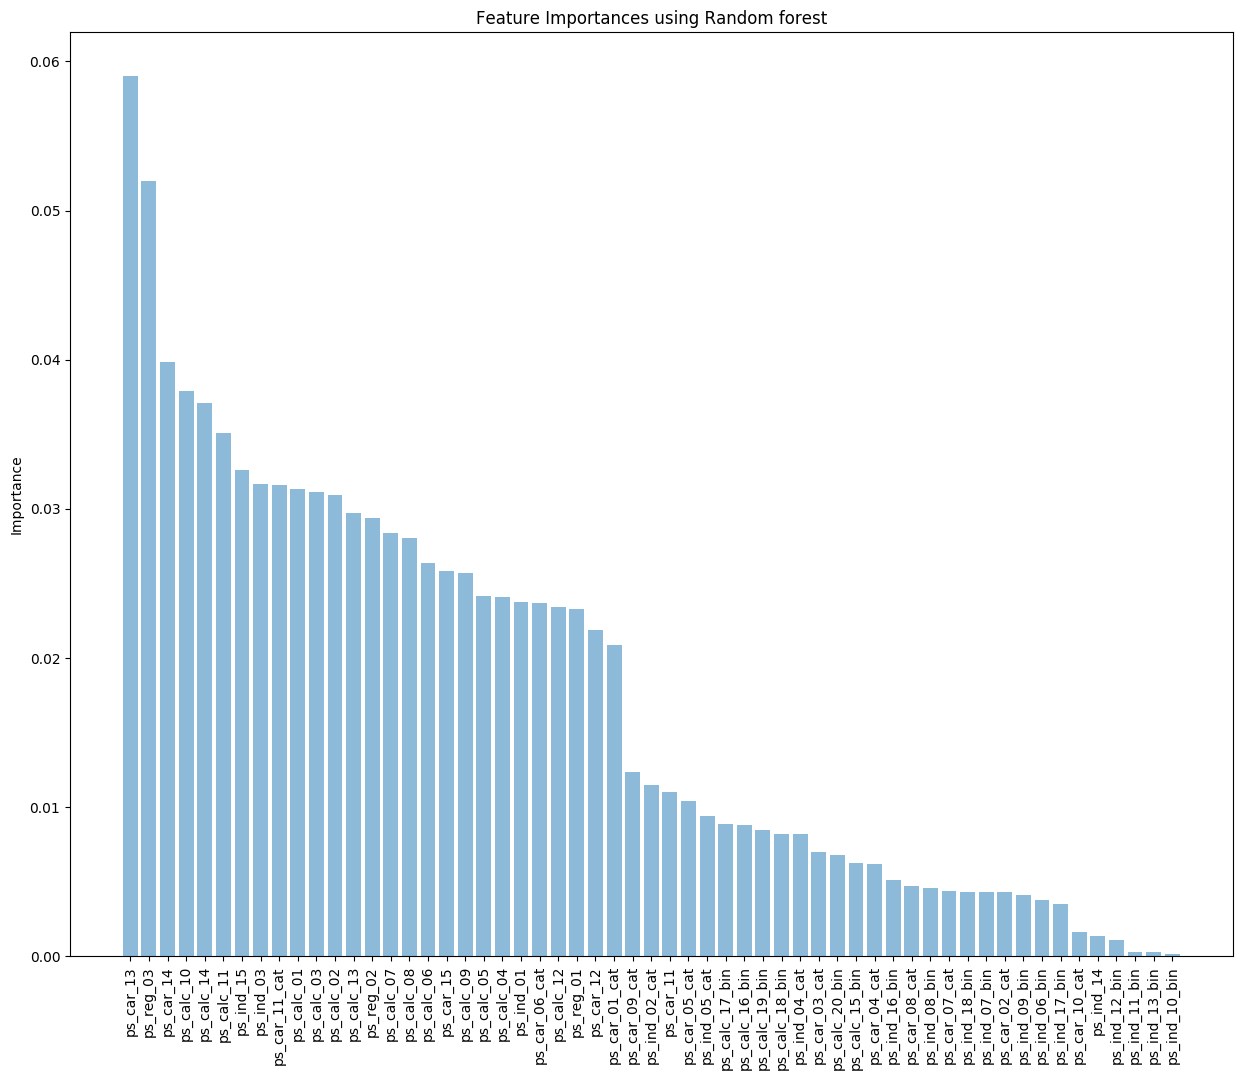

In [16]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
# Train the classifier
clf.fit(train.iloc[:,2:], train.iloc[:,1])

# Print the name and gini importance of each feature
feature_importances = sorted(zip(clf.feature_importances_, list(train.columns)[2:]), reverse=True)
objects = (list(zip(*feature_importances)[1]))
y_pos = np.arange(len(objects))
performance = np.array(zip(*feature_importances)[0])
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Importance')
plt.title('Feature Importances using Random forest')
plt.show()

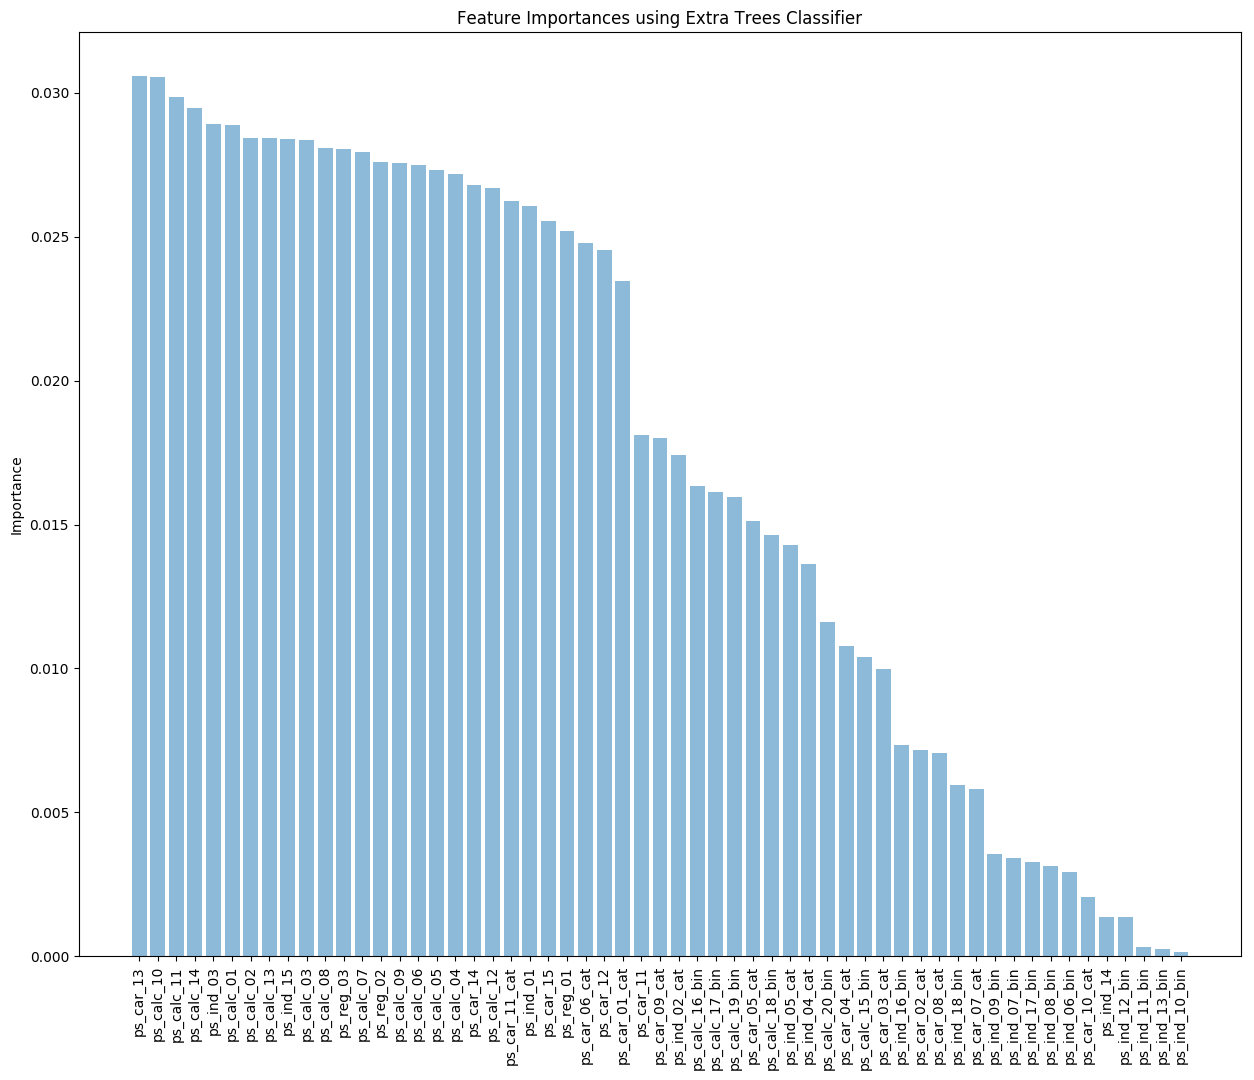

In [17]:
# Feature Importance
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(train.iloc[:,2:], train.iloc[:,1])


# Print the name and gini importance of each feature
feature_importances = sorted(zip(model.feature_importances_, list(train.columns)[2:]), reverse=True)
objects = (list(zip(*feature_importances)[1]))
y_pos = np.arange(len(objects))
performance = np.array(zip(*feature_importances)[0])
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Importance')
plt.title('Feature Importances using Extra Trees Classifier')
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


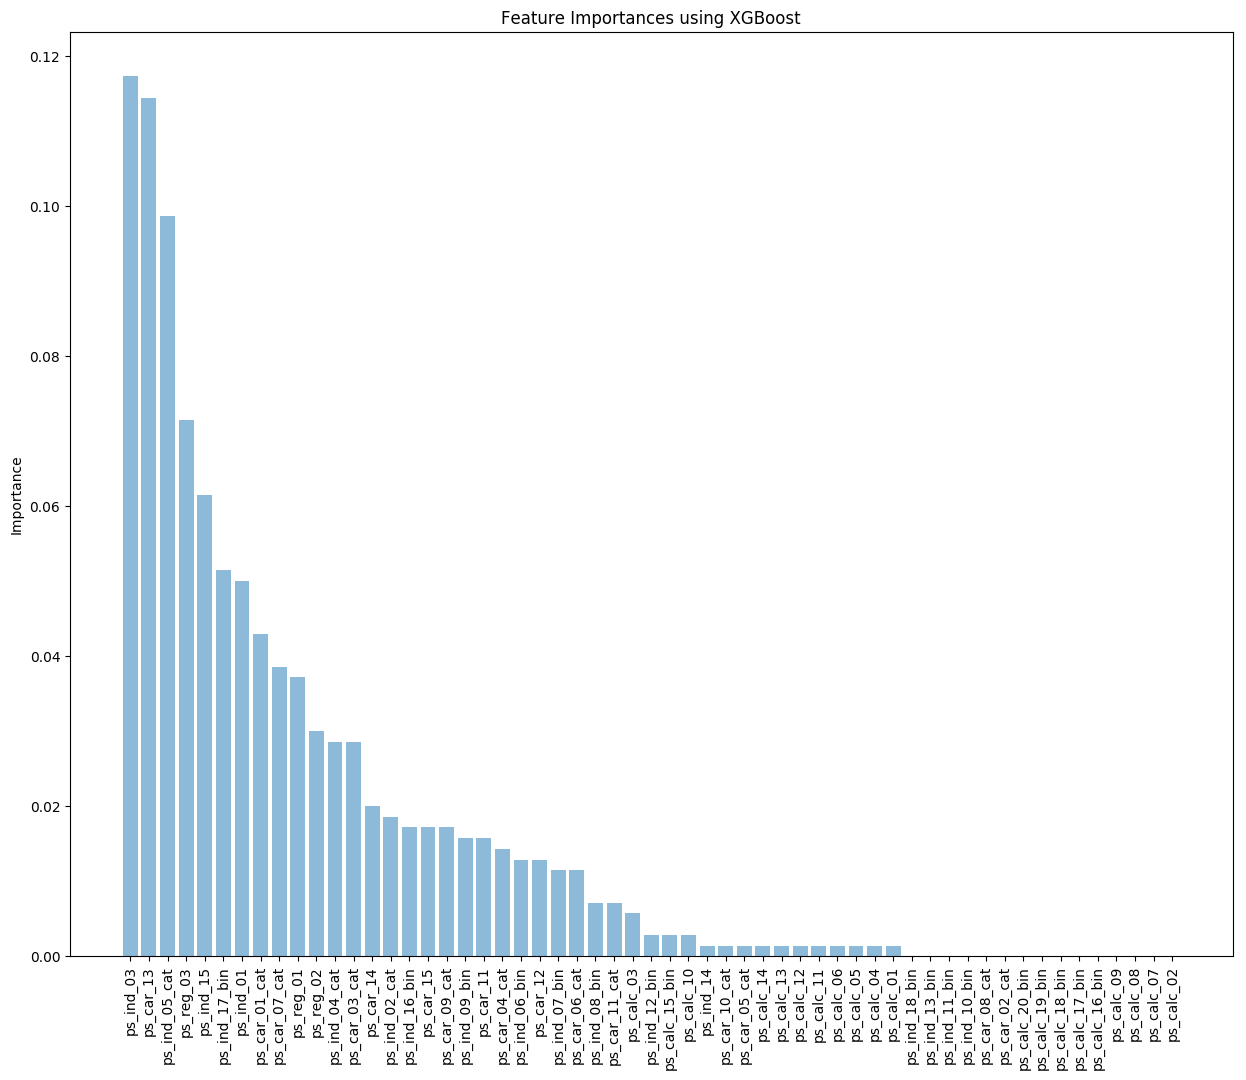

In [18]:
X = train.iloc[:,2:]
y = train.iloc[:,1]
# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# plot
feature_importances = sorted(zip(model.feature_importances_, list(train.columns)[2:]), reverse=True)
objects = (list(zip(*feature_importances)[1]))
y_pos = np.arange(len(objects))
performance = np.array(zip(*feature_importances)[0])
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Importance')
plt.title('Feature Importances using XGBoost')
plt.show()